In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

## prepare the dataset

In [4]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

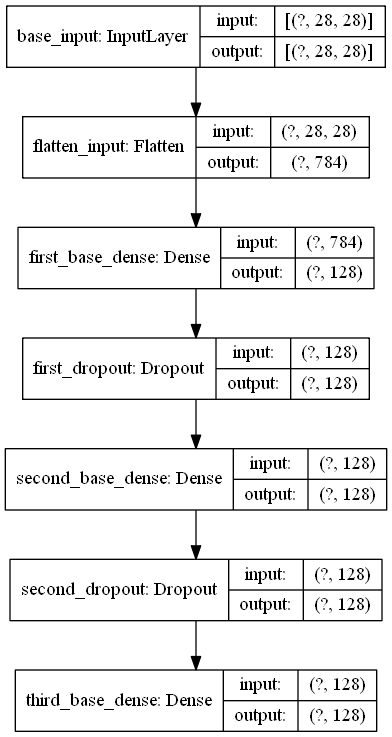

In [8]:

def initialize_base_network():
    input = tf.keras.Input(shape=(28,28,), name="base_input")
    x = tf.keras.layers.Flatten(name="flatten_input")(input)
    x = tf.keras.layers.Dense(128, activation='relu', name="first_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="first_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="second_base_dense")(x)
    x = tf.keras.layers.Dropout(0.1, name="second_dropout")(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="third_base_dense")(x)

    return tf.keras.Model(inputs=input, outputs=x)

base_network = initialize_base_network()
tf.keras.utils.plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [27]:
from tensorflow.keras import backend as K
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

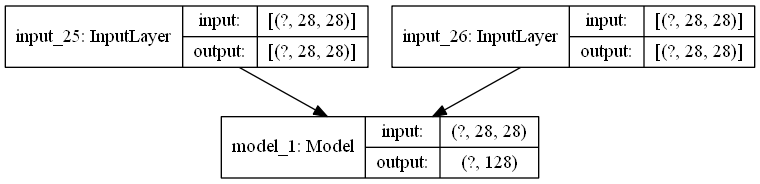

In [22]:
input_a = tf.keras.Input(shape=(28,28,))
input_b = tf.keras.Input(shape=(28,28,))
x1 = base_network(input_a)
x2 = base_network(input_b)
# output = tf.keras.layers.Lambda(euclidean_distance, name="output_layer", 
#                 output_shape=eucl_dist_output_shape)([x1, x2])

model = tf.keras.Model(inputs=[input_a,input_b],outputs=[x1,x2])
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')

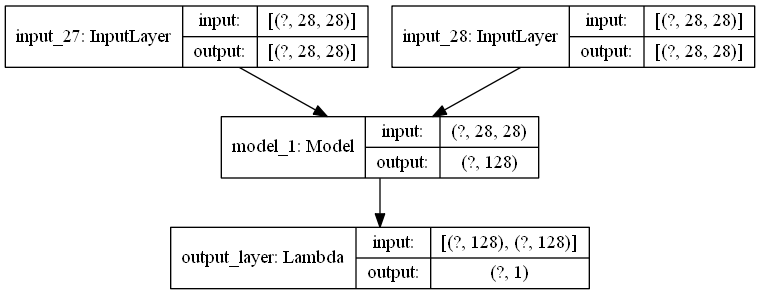

In [28]:
input_a = tf.keras.Input(shape=(28,28,))
input_b = tf.keras.Input(shape=(28,28,))
x1 = base_network(input_a)
x2 = base_network(input_b)
output = tf.keras.layers.Lambda(euclidean_distance, name="output_layer", 
                output_shape=eucl_dist_output_shape)([x1, x2])

model = tf.keras.Model(inputs=[input_a,input_b],outputs=output)
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [29]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [30]:
#try any other loss instead of contrasitive loss
rms = tf.keras.optimizers.RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, 
                    epochs=10, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Train on 119980 samples, validate on 19980 samples
Epoch 1/10
119980/119980 [==============================] - 10s 85us/sample - loss: 0.1130 - val_loss: 0.0887
Epoch 2/10
119980/119980 [==============================] - 7s 54us/sample - loss: 0.0797 - val_loss: 0.0729
Epoch 3/10
119980/119980 [==============================] - 6s 50us/sample - loss: 0.0705 - val_loss: 0.0702
Epoch 4/10
119980/119980 [==============================] - 6s 50us/sample - loss: 0.0648 - val_loss: 0.0666
Epoch 5/10
119980/119980 [==============================] - 6s 53us/sample - loss: 0.0623 - val_loss: 0.0654
Epoch 6/10
119980/119980 [==============================] - 6s 52us/sample - loss: 0.0601 - val_loss: 0.0664
Epoch 7/10
119980/119980 [==============================] - 6s 47us/sample - loss: 0.0587 - val_loss: 0.0673
Epoch 8/10
119980/119980 [==============================] - 6s 48us/sample - loss: 0.0570 - val_loss: 0.0642
Epoch 9/10
119980/119980 [==============================] - 6s 48us/sample -